In [1]:
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

from osgeo import osr

import pickle

import pyart
import datetime as dt
import numpy as np
import pandas as pd
import os


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
import matplotlib.patches as patches

In [3]:
# import os

# os.environ['LC_NUMERIC']='C'

Read the radar grid coordinates. These coordinates are in WGS84 CRS.

In [4]:
# Getting back the objects:
with open('radar_grid.pkl','rb') as f:  # Python 3: open(..., 'rb')
    x_rad, y_rad = pickle.load(f)

In [5]:
x_rad.shape

(300, 300)

Read the watershed shapefile.

In [6]:
# this file is in UTM
fname_shp = r'C:/Users/iac6311/Documents/Work/Data/GIS/USA/SAVEUR/city_detailed_utm.shp'

In [7]:
dataset, inLayer = wrl.io.open_vector(fname_shp)
borders, keys = wrl.georef.get_vector_coordinates(inLayer, key='node_id')

Define different projections that will be used in the processing.

In [8]:
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

proj_aeqd = osr.SpatialReference()
proj_aeqd.ImportFromEPSG(54032)

proj_IL = osr.SpatialReference()
proj_IL.ImportFromEPSG(26771)

proj_IL_UTM = osr.SpatialReference()
proj_IL_UTM.ImportFromEPSG(26916)

0

Put the two coordinate grids in one array.

In [9]:
grid_xy = np.zeros((300,300,2))

grid_xy[:,:,0] = x_rad
grid_xy[:,:,1] = y_rad

Reproject the radar grid to UTM, to match the shapefile.

In [10]:
grid_xy_utm = wrl.georef.reproject(grid_xy,
                                projection_source=proj_wgs,
                                projection_target=proj_IL_UTM)

# grid_xy_utm = wrl.georef.reproject(grid_xy,
#                                 projection_source=proj_aeqd,
#                                 projection_target=proj_IL_UTM)

In [11]:
grid_xy_utm

array([[[ 284847.57546232, 4485132.08909503],
        [ 285672.43041583, 4485122.09771765],
        [ 286497.28178539, 4485112.10541526],
        ...,
        [ 529731.16477703, 4482122.56077514],
        [ 530555.55719424, 4482112.28006985],
        [ 531379.95009244, 4482101.99834006]],

       [[ 284857.5242393 , 4485953.74522311],
        [ 285682.3801497 , 4485943.75093724],
        [ 286507.23247643, 4485933.75573553],
        ...,
        [ 529741.40993718, 4482943.75539302],
        [ 530565.80339401, 4482933.47449603],
        [ 531390.19733213, 4482923.19258367]],

       [[ 284867.47523913, 4486775.40233558],
        [ 285692.33210185, 4486765.40514143],
        [ 286517.18538117, 4486755.40704063],
        ...,
        [ 529751.6559627 , 4483764.95106108],
        [ 530576.05045459, 4483754.66997262],
        [ 531400.44542805, 4483744.38787791]],

       ...,

       [[ 287899.37109369, 4729207.35430143],
        [ 288724.30857893, 4729196.50906413],
        [ 289549.24256

In [12]:
x_rad_utm = grid_xy_utm[:,:,0]
y_rad_utm = grid_xy_utm[:,:,1]

Create a mask to reduce size.

In [13]:
# Reduce grid size using a bounding box (to enhancing performance)
bbox = inLayer.GetExtent()

In [14]:
print(bbox) # in UTM

(429833.0111856869, 454775.7552739343, 4619778.345386352, 4657770.209322866)


In [15]:
buffer = 5000.
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)
mask = (((grid_xy_utm[..., 1] > bbox['bottom']) & (grid_xy_utm[..., 1] < bbox['top'])) &
        ((grid_xy_utm[..., 0] > bbox['left']) & (grid_xy_utm[..., 0] < bbox['right'])))

In [16]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Have a look at the mask.

(300, 300)


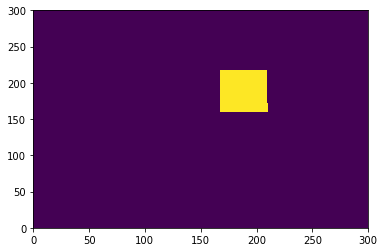

In [17]:
print(mask.shape)
plt.pcolormesh(mask)

In [18]:
# Create vertices for each grid cell
# (MUST BE DONE IN NATIVE COORDINATES)

grdverts = wrl.zonalstats.grid_centers_to_vertices(x_rad_utm[mask],
                                                   y_rad_utm[mask], 824,
                                                   824)

In [19]:
grdverts

array([[[ 424608.10031457, 4614448.68211735],
        [ 425432.10031457, 4614448.68211735],
        [ 425432.10031457, 4615272.68211735],
        [ 424608.10031457, 4615272.68211735],
        [ 424608.10031457, 4614448.68211735]],

       [[ 425432.64777443, 4614438.31426381],
        [ 426256.64777443, 4614438.31426381],
        [ 426256.64777443, 4615262.31426381],
        [ 425432.64777443, 4615262.31426381],
        [ 425432.64777443, 4614438.31426381]],

       [[ 426257.19399653, 4614427.94689258],
        [ 427081.19399653, 4614427.94689258],
        [ 427081.19399653, 4615251.94689258],
        [ 426257.19399653, 4615251.94689258],
        [ 426257.19399653, 4614427.94689258]],

       ...,

       [[ 457367.29672235, 4661688.45404447],
        [ 458191.29672235, 4661688.45404447],
        [ 458191.29672235, 4662512.45404447],
        [ 457367.29672235, 4662512.45404447],
        [ 457367.29672235, 4661688.45404447]],

       [[ 458191.81493005, 4661678.04839856],
        [ 459

In [20]:
# # And reproject to Cartesian reference system (here: UTM)
# grdverts = wrl.georef.reproject(grdverts,
#                                 projection_source=proj_wgs,
#                                 projection_target=proj_IL_UTM)

In [21]:
grdverts.shape

(2456, 5, 2)

In [22]:
x_rad

array([[-89.53860964, -89.52888271, -89.51915575, ..., -86.64917921,
        -86.63945225, -86.62972532],
       [-89.53877123, -89.52904323, -89.51931519, ..., -86.64901978,
        -86.63929173, -86.62956373],
       [-89.53893288, -89.52920379, -89.51947467, ..., -86.64886029,
        -86.63913117, -86.62940208],
       ...,
       [-89.58898186, -89.57891828, -89.56885465, ..., -86.59948031,
        -86.58941668, -86.5793531 ],
       [-89.5891599 , -89.57909512, -89.56903031, ..., -86.59930466,
        -86.58923984, -86.57917506],
       [-89.58933799, -89.57927202, -89.56920602, ..., -86.59912894,
        -86.58906294, -86.57899697]])

In [23]:
y_rad

array([[40.48902186, 40.48914524, 40.48926779, ..., 40.48926779,
        40.48914524, 40.48902186],
       [40.49641948, 40.49654288, 40.49666546, ..., 40.49666546,
        40.49654288, 40.49641948],
       [40.5038171 , 40.50394053, 40.50406312, ..., 40.50406312,
        40.50394053, 40.5038171 ],
       ...,
       [42.68609643, 42.68622594, 42.68635458, ..., 42.68635458,
        42.68622594, 42.68609643],
       [42.69349392, 42.69362345, 42.69375211, ..., 42.69375211,
        42.69362345, 42.69349392],
       [42.70089141, 42.70102096, 42.70114964, ..., 42.70114964,
        42.70102096, 42.70089141]])

In [24]:
grdverts[0]

array([[ 424608.10031457, 4614448.68211735],
       [ 425432.10031457, 4614448.68211735],
       [ 425432.10031457, 4615272.68211735],
       [ 424608.10031457, 4615272.68211735],
       [ 424608.10031457, 4614448.68211735]])

424608.1003145724
4614448.682117352
425432.1003145724
4614448.682117352
425432.1003145724
4615272.682117352
424608.1003145724
4615272.682117352
424608.1003145724
4614448.682117352


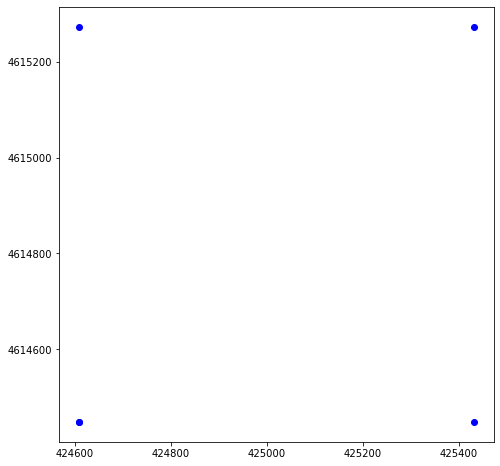

In [25]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

for i in range(len(grdverts[0])):
    print(grdverts[0][i][0])
    print(grdverts[0][i][1])
    x = grdverts[0][i][0]
    y = grdverts[0][i][1]
    ax.plot(x,y,'bo')
    #plt.set_xlim(np.min(grdverts[0])-100,)

In [26]:
np.min(grdverts[0])

424608.1003145724

Create instance of type ZonalDataPoly from source grid and catchment array. This needs to be done only once, then dump to file. The files that will be saved are the `src` shapefile (radar pixels), `trg` shapefile (original catchment), and `dst` shapefile (the radar pixels cut according to `trg`). 

In [27]:
borders

array([array([[ 436756.71818262, 4646857.36044042],
       [ 436766.34952442, 4646902.414535  ],
       [ 436789.07418281, 4646894.50034369],
       [ 436815.47399175, 4646887.63295437],
       [ 436902.93912884, 4646886.1378362 ],
       [ 436960.95122718, 4646844.55174357],
       [ 437103.69216772, 4646740.93084579],
       [ 437278.99170261, 4646599.92524794],
       [ 437379.59303903, 4646542.05870377],
       [ 437373.75237394, 4646523.70268888],
       [ 437496.64526745, 4646424.85143676],
       [ 437505.50802888, 4646434.47171884],
       [ 437552.92785577, 4646395.83713081],
       [ 437682.38991352, 4646290.359696  ],
       [ 437716.17943166, 4646248.26521431],
       [ 437747.17628564, 4646223.33238283],
       [ 437833.70741198, 4646129.89939992],
       [ 437868.88165185, 4646099.68815832],
       [ 437895.43183658, 4646083.62759679],
       [ 437907.7365234 , 4646076.18423268],
       [ 437982.68837633, 4646037.1071062 ],
       [ 438057.68269304, 4646006.13409282],
   

In [28]:
%%time
# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(grdverts, borders)

Wall time: 14.1 s


In [29]:
%%time
# dump to file
zd.dump_vector('zonal_poly_cart_test')

RuntimeError: Layer 'src' already exists

In [30]:
%%time
# Create instance of type ZonalStatsPoint from zonal data object
obj3 = wrl.zonalstats.ZonalStatsPoly(zd)

Wall time: 6min 14s


### Now the looping can happen

Read the gridded data.

In [40]:
file_dir = "./gridded_KLOT_RR"
gridded_files = os.listdir(file_dir)
gridded_files = [f for f in gridded_files if f.endswith('_rrA.hdf5')]

In [41]:
def testplot(cats, catsavg, xy, data, savefname,
             levels=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100, 150],
             title=""):
    """Quick test plot layout for this example file
    """
    colors = plt.cm.viridis(np.linspace(0, 1, len(levels)))
    mycmap, mynorm = from_levels_and_colors(levels, colors, extend="max")

    radolevels = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100, 150]
    radocolors = pyart.graph.cm_colorblind.HomeyerRainbow(np.linspace(0, 1, len(radolevels)))
    #pyart.graph.cm_colorblind()
    radocmap, radonorm = from_levels_and_colors(radolevels, radocolors,
                                                extend="max")

    fig = plt.figure(figsize=(18, 10))

    # Average rainfall sum
    ax = fig.add_subplot(122, aspect="equal")
    coll = PatchCollection(cats, array=catsavg, cmap=radocmap, norm=mynorm,
                           edgecolors='white', lw=0.5)
    ax.add_collection(coll)
    ax.autoscale()
    plt.colorbar(coll, ax=ax, shrink=0.5)
    plt.xlabel("NAD83 Z16 Easting")
    plt.ylabel("NAD83 Z16 Northing")
    plt.title(title)
    plt.draw()

    # Original radar data
    ax1 = fig.add_subplot(121, aspect="equal")
    pm = plt.pcolormesh(xy[:, :, 0], xy[:, :, 1], np.ma.masked_invalid(data),
                        cmap=radocmap, norm=radonorm)
    coll = PatchCollection(cats, facecolor='None', edgecolor='k', lw=0.1)
    ax1.add_collection(coll)
    cb = plt.colorbar(pm, ax=ax1, shrink=0.5)
    cb.set_label("(mm/h)")
    plt.xlabel("NAD83 Z16 Easting")
    plt.ylabel("NAD83 Z16 Northing")
    plt.title("Original radar rain sums: " + savefname.strip('.png'))
    ax1.set_xlim(bbox['left']-10000,bbox['right']+10000)
    ax1.set_ylim(bbox['bottom']-10000,bbox['top']+10000)
    #plt.draw()
    plt.tight_layout()
    fig.savefig(savefname)
    plt.close()

In [33]:
keys_str = [str(f) for f in keys]

In [34]:
gridded_files

['gridded_KLOT20130417_010000_rrA.hdf5',
 'gridded_KLOT20130417_020000_rrA.hdf5',
 'gridded_KLOT20130417_030000_rrA.hdf5',
 'gridded_KLOT20130417_040000_rrA.hdf5',
 'gridded_KLOT20130417_050000_rrA.hdf5',
 'gridded_KLOT20130417_060000_rrA.hdf5',
 'gridded_KLOT20130417_070000_rrA.hdf5',
 'gridded_KLOT20130417_080000_rrA.hdf5',
 'gridded_KLOT20130417_090000_rrA.hdf5',
 'gridded_KLOT20130417_100000_rrA.hdf5',
 'gridded_KLOT20130417_110000_rrA.hdf5',
 'gridded_KLOT20130417_120000_rrA.hdf5',
 'gridded_KLOT20130417_130000_rrA.hdf5',
 'gridded_KLOT20130417_140000_rrA.hdf5',
 'gridded_KLOT20130417_150000_rrA.hdf5',
 'gridded_KLOT20130417_160000_rrA.hdf5',
 'gridded_KLOT20130417_170000_rrA.hdf5',
 'gridded_KLOT20130417_180000_rrA.hdf5',
 'gridded_KLOT20130417_190000_rrA.hdf5',
 'gridded_KLOT20130417_200000_rrA.hdf5',
 'gridded_KLOT20130417_210000_rrA.hdf5',
 'gridded_KLOT20130417_220000_rrA.hdf5',
 'gridded_KLOT20130417_230000_rrA.hdf5',
 'gridded_KLOT20130418_000000_rrA.hdf5',
 'gridded_KLOT20

In [35]:
# create empty dataframe where we will put the extracted values
df = pd.DataFrame()

for f in gridded_files:
    print(f)
    fn = os.path.join(file_dir, f)
    data, attrs = wrl.io.from_hdf5(fn)

    # mask data to reduce size
    data_ = data[mask]
    # Compute stats for target polygons
    avg3 = obj3.mean(data_.ravel())
    
    # Target polygon patches
    trg_patches = [patches.Polygon(item, True) for item in obj3.zdata.trg.data]
    
    # set save filename
    savefname = fn.rsplit('\\')[-1].rsplit('.')[0].strip('gridded_')+'.png'
    
    # get time
    dtime = str(dt.datetime.strptime(fn.rsplit('\\')[-1].rsplit('.')[0],'gridded_KLOT%Y%m%d_%H%M%S_rrA'))
    
    # plot
    testplot(trg_patches, avg3, grid_xy_utm, data, savefname,
         title="Catchment rainfall mean (ZonalStatsPoly)")
    
    # put to dataframe
    df_ = pd.DataFrame(data=[avg3],columns=keys)
    df_['DateTime'] = dtime
    
    df = df.append(df_)


gridded_KLOT20130417_010000_rrA.hdf5
gridded_KLOT20130417_020000_rrA.hdf5
gridded_KLOT20130417_030000_rrA.hdf5
gridded_KLOT20130417_040000_rrA.hdf5
gridded_KLOT20130417_050000_rrA.hdf5
gridded_KLOT20130417_060000_rrA.hdf5
gridded_KLOT20130417_070000_rrA.hdf5
gridded_KLOT20130417_080000_rrA.hdf5
gridded_KLOT20130417_090000_rrA.hdf5
gridded_KLOT20130417_100000_rrA.hdf5
gridded_KLOT20130417_110000_rrA.hdf5
gridded_KLOT20130417_120000_rrA.hdf5
gridded_KLOT20130417_130000_rrA.hdf5
gridded_KLOT20130417_140000_rrA.hdf5
gridded_KLOT20130417_150000_rrA.hdf5
gridded_KLOT20130417_160000_rrA.hdf5
gridded_KLOT20130417_170000_rrA.hdf5
gridded_KLOT20130417_180000_rrA.hdf5
gridded_KLOT20130417_190000_rrA.hdf5
gridded_KLOT20130417_200000_rrA.hdf5
gridded_KLOT20130417_210000_rrA.hdf5
gridded_KLOT20130417_220000_rrA.hdf5
gridded_KLOT20130417_230000_rrA.hdf5
gridded_KLOT20130418_000000_rrA.hdf5
gridded_KLOT20130418_010000_rrA.hdf5
gridded_KLOT20130418_020000_rrA.hdf5
gridded_KLOT20130418_030000_rrA.hdf5
g

In [36]:
dtime

'2013-04-19 00:00:00'

In [37]:
df.to_csv('case_study_20130417_20130418_hourlyrainfall_chicago_catchments_NODEIDS_rrA.csv')

Wall time: 8.34 s


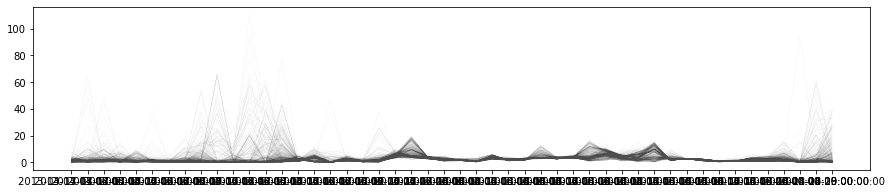

In [38]:
%%time
plt.figure(figsize=[15,3])
for key in keys[0:10000:20]:
    plt.plot(df['DateTime'], df[key], color='0.3',alpha=0.1, lw=0.1)

In [39]:
data.shape

(300, 300)